In [179]:
import xarray as xr
import numpy as np
import copernicusmarine
import matplotlib.pyplot as plt
import matplotlib
import os
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from ndbc_api import NdbcApi
from datetime import datetime, timedelta
import requests, tarfile, tqdm
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import glob
from cartopy.feature import GSHHSFeature
import cartopy.io.shapereader as shpreader
import matplotlib.dates as mdates
plt.rcParams['font.family'] = 'Helvetica'  # Clean and modern
# plt.rcParams['font.family'] = 'DejaVu Sans'  # Has full font weights


In [180]:
# Set up dates and get station data
today = datetime.today()
dates = {
    'today': today.strftime('%Y-%m-%d'),
    'yesterday': (today - timedelta(days=1)).strftime('%Y-%m-%d'),
    'tomorrow': (today + timedelta(days=3)).strftime('%Y-%m-%d')
}

time_range = pd.date_range(
    start=dates['yesterday'],
    end=dates['tomorrow'],
    freq='D'
)

yday = "".join(dates["yesterday"].split("-"))
tday = "".join(dates["today"].split("-"))

In [181]:
# Get station info
api = NdbcApi()
# station_id = '44090' #Nantucket
# station_id = '46221' #LA
station_id = 'BZBM3'; station_name = "Woods Hole, MA"
station_meta = api.station(station_id=station_id)
location = station_meta["Location"].split()
latitude = float(location[0]) * (-1 if location[1] in ['S'] else 1)
longitude = float(location[2]) * (-1 if location[3] in ['W'] else 1)

In [182]:
bathy = xr.open_dataset("gebco_woho.nc").elevation
bathy = bathy.where(bathy < 0)

In [183]:
# Get and process buoy data
stdmet_df = (api.get_data(station_ids=[station_id], mode='stdmet',
                         start_time=dates['yesterday'],
                         end_time=dates['tomorrow'])
             .rename_axis(index='time')
             .pipe(xr.Dataset.from_dataframe))
stdmet_df_final = stdmet_df.isel(time=~stdmet_df["WTMP"].isnull().values).isel(time=-1)

Printing around [-71.07100000000001, -70.271, 41.124, 41.924]


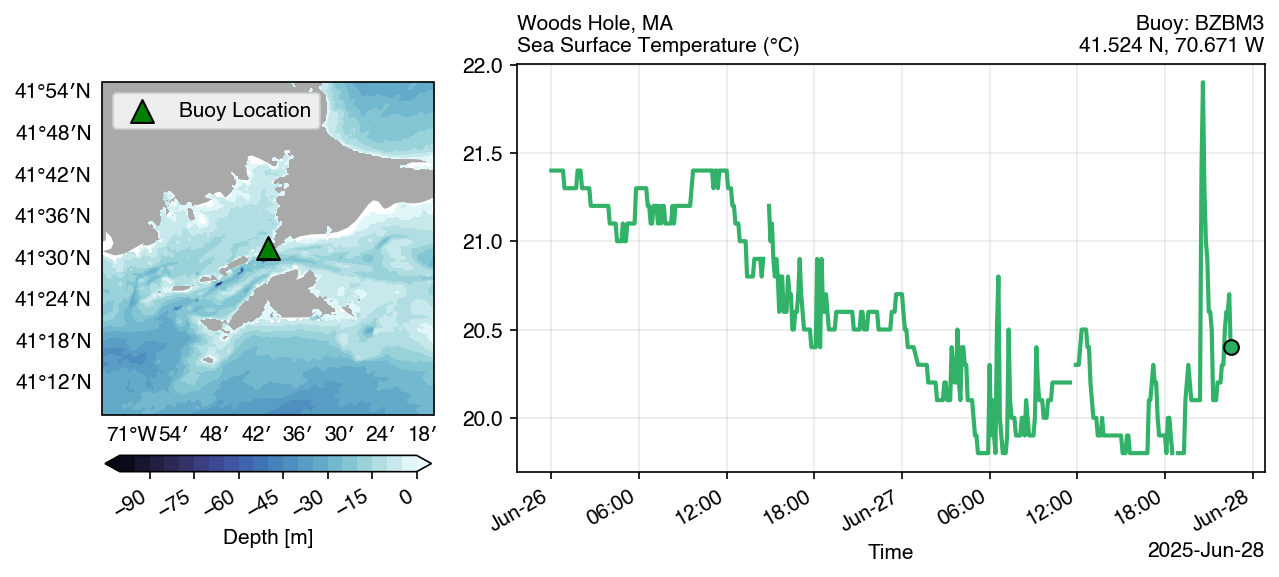

In [190]:
# Create plot
fig = plt.figure(figsize=(10, 4), facecolor='white', dpi=150)
gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.25)

# Map subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='darkgrey')

contour = ax1.contourf(bathy.lon, bathy.lat, 
                        bathy,
                       levels = np.arange(-100, 0.1, 5),
                        transform=ccrs.PlateCarree(),
                        cmap=cmocean.cm.ice, extend = "both")
fig.colorbar(contour, ax=ax1, orientation='horizontal', 
            pad=0.1, fraction=0.04, label='Depth [m]',
            extend="both")


# Example bounding box: [lon_min, lon_max, lat_min, lat_max]

dlon = 0.4; dlat = 0.4 
extent = [longitude - dlon, longitude + dlon, latitude-dlat, latitude+dlat]
print(f"Printing around {extent}")
ax1.set_extent(extent)  # Zoom around Woods Hole

# Add gridlines and map features
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                   linewidth=0.5, color='gray', alpha=0.01, linestyle='--')
gl.top_labels = gl.right_labels = False

# Add temperature contour

# Add buoy marker
ax1.scatter(longitude, latitude, c='green', s=120, marker='^', 
           transform=ccrs.PlateCarree(), 
            label='Buoy Location', 
            alpha = 1, zorder = 100, edgecolor='black')
ax1.legend(loc='upper left')

# Time series subplot
ax2 = fig.add_subplot(gs[0, 1:])
# ax2.set_title(f"Sea Surface Temperature (°C) at {' '.join(location[0:4])}", fontweight="bold")

# Add left-justified title
ax2.text(0.0, 1.02, f"{station_name}\nSea Surface Temperature (°C)",
    transform=ax2.transAxes, ha='left', va='bottom', fontweight='bold')

# Add right-justified location
ax2.text(1.0, 1.02, f"Buoy: {station_id}\n{' '.join(location[0:2])}, {' '.join(location[2:4])}",
    transform=ax2.transAxes, ha='right', va='bottom')

ax2.grid(True, linestyle='-', alpha=0.25, zorder = 0)

# Add time series
stdmet_df["WTMP"].plot(ax=ax2, color='#27ae60', linewidth=2, alpha = 0.95)
ax2.scatter(stdmet_df_final.time, stdmet_df_final["WTMP"].values, 
            color='#27ae60', 
            # label='Latest Buoy Data', 
            s=50, edgecolor='black', zorder=5)

# Format time series
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax2.set_xlabel('Time')
ax2.set_ylabel("")
ax2.figure.autofmt_xdate()  # Auto-rotate labels
